In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('df_all_fights.csv')
df.columns = df.columns.str.strip()

num_cols = [
    'strike_accuracy_diff',
    'total_strike_accuracy_diff',
    'knockdowns_diff',
    'takedown_accuracy_diff',
    'takedowns_diff',
    'submission_attempts_diff'
]
cat_cols = ['weight_class', 'method']

df_clean = df[num_cols + cat_cols].dropna()

X_pos = df_clean.copy()
y_pos = np.ones(len(X_pos))

X_neg = df_clean.copy()
X_neg[num_cols] = -X_neg[num_cols]
y_neg = np.zeros(len(X_neg))

X = pd.concat([X_pos, X_neg], ignore_index=True)
y = np.concatenate([y_pos, y_neg])


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocess = ColumnTransformer([
    ('scale', StandardScaler(), num_cols),
    ('encode', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [4]:
models_to_test = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}


In [5]:
model_scores = {}

for label, model in models_to_test.items():
    pipeline = ImbPipeline([
        ('prep', preprocess),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    f1 = f1_score(y_test, preds)
    model_scores[label] = f1

    print(f"== {label} ==")
    print(classification_report(y_test, preds, digits=3))
    print("-" * 50)


== Naive Bayes ==
              precision    recall  f1-score   support

         0.0      0.731     0.756     0.743       291
         1.0      0.776     0.752     0.764       327

    accuracy                          0.754       618
   macro avg      0.753     0.754     0.754       618
weighted avg      0.755     0.754     0.754       618

--------------------------------------------------
== KNN ==
              precision    recall  f1-score   support

         0.0      0.816     0.790     0.803       291
         1.0      0.818     0.841     0.830       327

    accuracy                          0.817       618
   macro avg      0.817     0.816     0.816       618
weighted avg      0.817     0.817     0.817       618

--------------------------------------------------
== Random Forest ==
              precision    recall  f1-score   support

         0.0      0.817     0.859     0.838       291
         1.0      0.869     0.829     0.848       327

    accuracy                    

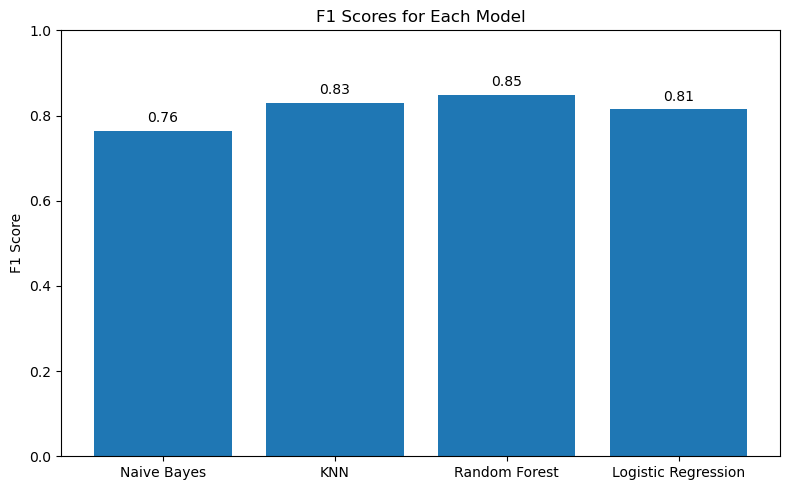

In [6]:
plt.figure(figsize=(8, 5))
bars = plt.bar(model_scores.keys(), model_scores.values())
plt.ylim(0, 1)
plt.title("F1 Scores for Each Model")
plt.ylabel("F1 Score")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')

plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report, brier_score_loss
import matplotlib.pyplot as plt


In [8]:
df = pd.read_csv('df_all_fights.csv')
df.columns = df.columns.str.strip()

num_cols = [
    'strike_accuracy_diff',
    'total_strike_accuracy_diff',
    'knockdowns_diff',
    'takedown_accuracy_diff',
    'takedowns_diff',
    'submission_attempts_diff'
]

cat_cols = ['weight_class', 'method']

base_feats = df[num_cols + cat_cols].dropna()

y_win = np.ones(len(base_feats), dtype=int)

flipped_feats = base_feats.copy()
flipped_feats[num_cols] = -flipped_feats[num_cols]

y_lose = np.zeros(len(flipped_feats), dtype=int)

X_total = pd.concat([base_feats, flipped_feats], ignore_index=True)
y_total = np.concatenate([y_win, y_lose])


In [9]:
feat_transform = ColumnTransformer([
    ('std', StandardScaler(), num_cols),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipe_rf = Pipeline([
    ('xform', feat_transform),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

cal_rf = CalibratedClassifierCV(estimator=pipe_rf, method='sigmoid', cv=5)


In [10]:
prob_preds = cross_val_predict(cal_rf, X_total, y_total, cv=5, method='predict_proba')[:, 1]
final_preds = (prob_preds >= 0.5).astype(int)

print("== Random Forest with Calibration ==")
print(classification_report(y_total, final_preds))
print("Brier Score:", brier_score_loss(y_total, prob_preds))


== Random Forest with Calibration ==
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1545
           1       0.83      0.82      0.83      1545

    accuracy                           0.83      3090
   macro avg       0.83      0.83      0.83      3090
weighted avg       0.83      0.83      0.83      3090

Brier Score: 0.12001227105051927


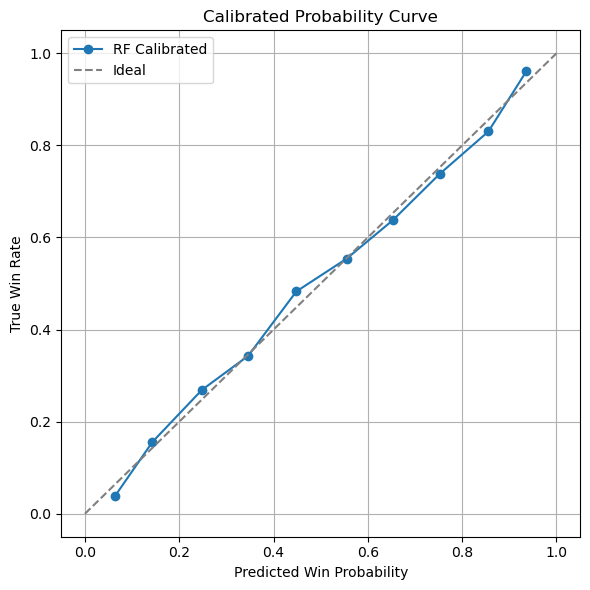

In [11]:
cal_y, cal_x = calibration_curve(y_total, prob_preds, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(cal_x, cal_y, 'o-', label='RF Calibrated')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal')
plt.title("Calibrated Probability Curve")
plt.xlabel("Predicted Win Probability")
plt.ylabel("True Win Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import joblib

cal_rf.fit(X_total, y_total)
joblib.dump(cal_rf, "model.pkl")
print("model.pkl saved")


model.pkl saved
